In [1]:
from fastai.vision.all import *
from fastai.data.all import *


In [2]:
# DATASET_NAME = 'DEEP_GLOBE_LAND_COVER'
# CODE_NAMES = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# DATASET_NAME = 'DEEP_GLOBE_ROAD_EXTRACTION'
# CODE_NAMES = ['road', 'background']

# DATASET_NAME = 'FISH'
# CODE_NAMES = ['fish', 'background']

DATASET_NAME = 'SEVERSTAL'
CODE_NAMES = [0, 1, 2, 3, 4]

In [3]:
PROJ_PATH = Path(os.getcwd())
DATA_PATH = PROJ_PATH/'data'
TRAIN_PATH = DATA_PATH/DATASET_NAME
TRAIN_PATH

Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL')

In [4]:
fpaths = get_image_files(TRAIN_PATH/'images')
fpaths

(#6666) [Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/1e7893a11.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/f20023b87.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/935654dc9.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/51f9ccdd2.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/82e32c810.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/2cfa7ea6f.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/5600ec21b.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/0d9d2aa59.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/ce02c322e.jpg'),Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/images/1cb27ff90.jpg')...]

In [5]:
def get_mask_path(img_path): 
    msk_path = fpaths[0].parent.parent/'labels'/f'{img_path.stem}.png'
    return msk_path

get_mask_path(fpaths[0])

Path('/home/ubuntu/github/cv_fastai/segmentation/data/SEVERSTAL/labels/1e7893a11.png')

In [6]:
img = Image.open(fpaths[0])
img.size

(1600, 256)

In [7]:
if min(img.size) > 1024:
    sz = 1024
elif min(img.size) < 100:
    import warnings
    warnings.warn(f"Image size of {img.size} is very small")
    sz = min(img.size)
else:
    sz = min(img.size)

item_tfms_sz = sz
batch_tfms_sz = sz
item_tfms_sz, batch_tfms_sz

(256, 256)

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unp

TensorImage(-2.1179, device='cuda:0') TensorImage(2.5863, device='cuda:0')
TensorMask(0, device='cuda:0') TensorMask(1, device='cuda:0')


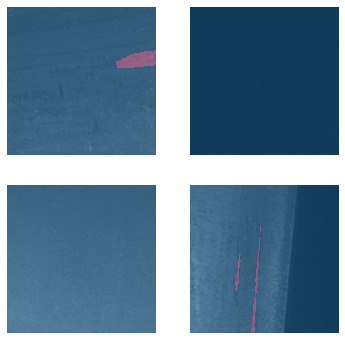

In [8]:
dls = SegmentationDataLoaders.from_label_func(
    path=TRAIN_PATH, 
    fnames=get_image_files(TRAIN_PATH/'images'),
    label_func=get_mask_path,
    codes=CODE_NAMES,
    bs=4, 
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms = Resize(item_tfms_sz),
    batch_tfms =[*aug_transforms(size=batch_tfms_sz), 
                 Normalize.from_stats(*imagenet_stats)]
)

dls.show_batch()
batch = dls.one_batch()
print(batch[0].min(), batch[0].max())
print(batch[1].min(), batch[1].max())

In [9]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(5333, 1333, 6666)

In [10]:
metrics = [DiceMulti]  

In [11]:
pickle_fpath = TRAIN_PATH/'export_learn_obj.pkl'
learn = unet_learner(dls, resnet34, metrics=metrics)

if (pickle_fpath).exists():
    learn = load_learner(pickle_fpath)
    learn.dls = dls
else:
    learn.fine_tune(2)
    learn.export(fname=pickle_fpath)

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.show_results()

In [ ]:
loss_val, dice_val = learn.validate()
loss_val, dice_val

In [14]:
# interp = SegmentationInterpretation.from_learner(learn)
# interp.plot_top_losses(10,figsize=(10,40))